## Initial data transformation and processing

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data_array = sio.loadmat('data/DATASET.mat')['DATASET']

Original dataset has all variables as imaginary numbers, for most of them the imaginary part is zero. But for FFT variables imaginary part is non-zero.

We'll split variables with imaginary part in real and imaginary as separate variables. Then, all variables will be represented as floats.

In [3]:
# Get only real part
data_float = data_array.copy().real.astype(float)
# Get imaginary part
imaginary_L_FFT = data_array.imag[:, 597:797]
imaginary_R_FFT = data_array.imag[:, 797:997]
# Array with all variables as float (includding imaginary part as a separate variable)
all_float_array = np.hstack((data_float[:, :997], imaginary_L_FFT, imaginary_R_FFT, data_float[:, 997:]))

In [4]:
# Imaginary components are now separated
print 'original dataset shape:', data_array.shape
print 'all floats dataset shape:', all_float_array.shape

original dataset shape: (65600, 1039)
all floats dataset shape: (65600, 1439)


Now we will include feature names:

In [5]:
column_names = []
# Time series
for i in range(200):
    column_names.append('L_HRIR_{:d}'.format(i))
for i in range(200):
    column_names.append('R_HRIR_{:d}'.format(i))
    
# Frequency Series
for i in range(98):
    column_names.append('L_HRTF_{:d}'.format(i))
for i in range(98):
    column_names.append('R_HRTF_{:d}'.format(i))

# Complex Response
for i in range(200):
    column_names.append('L_FFT_real_{:d}'.format(i))
for i in range(200):
    column_names.append('R_HRIR_real_{:d}'.format(i))
for i in range(200):
    column_names.append('L_FFT_imag_{:d}'.format(i))
for i in range(200):
    column_names.append('R_HRIR_imag_{:d}'.format(i))
# Interaction Parameters
# Time-arrival Difference
column_names.append('ITD')
# Intensity Difference
column_names.append('IID')
# Spectral Difference
column_names.append('DS')
# Head Parameters
column_names.append('head_width')
column_names.append('head_height')
column_names.append('head_depth')
column_names.append('pinna_offset_down')
column_names.append('pinna_offset_back')
column_names.append('neck_width')
column_names.append('neck_height')
column_names.append('neck_depth')
column_names.append('torso_top_width')
column_names.append('torso_top_heigth')
column_names.append('torso_top_depth')
column_names.append('shoulder_width')
column_names.append('head_offset_forward')
column_names.append('height')
column_names.append('seated_height')
column_names.append('head_circumference ')
column_names.append('shoulder_circumference')

# Ear Parameters
column_names.append('L_cavum_concha_heigth')
column_names.append('L_cymba_concha_heigth')
column_names.append('L_cavum_concha_width')
column_names.append('L_fossa_height')
column_names.append('L_pinna_height')
column_names.append('L_pinna_width')
column_names.append('L_intertragal_incisure_width')
column_names.append('L_cavum_concha_depth')
column_names.append('R_cavum_concha_heigth')
column_names.append('R_cymba_concha_heigth')
column_names.append('R_cavum_concha_width')
column_names.append('R_fossa_height')
column_names.append('R_pinna_height')
column_names.append('R_pinna_width')
column_names.append('R_intertragaR_incisure_width')
column_names.append('R_cavum_concha_depth')

# Pinnae Rotation Parameters
column_names.append('L_pinna_rotation_angle')
column_names.append('L_pinna_flare_angle')
column_names.append('R_pinna_rotation_angle')
column_names.append('R_pinna_flare_angle')

# Target
column_names.append('azimuth')
column_names.append('elevation')

# Subject Id
column_names.append('subject_id')

In [6]:
# Build Pandas DataFrame
df = pd.DataFrame(all_float_array, columns=column_names)

In [7]:
# col_ix Dictionary can be used to get the index of any feature
col_ix = {}
for i, col in enumerate(df.columns):
    col_ix[col] = i

In [8]:
# Should match the number of colums in dataset
len(column_names)

1439

In [9]:
# Number of unique azimuth, elevation and subject_id values
print 'azimuth: \nunique', df.azimuth.nunique(), '\n', df.azimuth.describe().transpose()
print 'elevation: \n unique', df.elevation.nunique(), df.elevation.describe().transpose()
print 'subject_id:', df.subject_id.nunique()

azimuth: 
unique 60 
count    65600.000000
mean        -4.321646
std        107.656501
min       -180.000000
25%       -100.000000
50%         -0.000000
75%         80.000000
max        175.000000
Name: azimuth, dtype: float64
elevation: 
 unique 32 count    65600.000000
mean        17.841797
std         40.146042
min        -50.625000
25%        -16.875000
50%         16.875000
75%         50.625000
max         90.000000
Name: elevation, dtype: float64
subject_id: 95


In [10]:
df.elevation.unique()

array([-45.   , -39.375, -33.75 , -28.125, -22.5  , -16.875, -11.25 ,
        -5.625,   0.   ,   5.625,  11.25 ,  16.875,  22.5  ,  28.125,
        33.75 ,  39.375,  45.   ,  50.625,  56.25 ,  61.875,  67.5  ,
        73.125,  78.75 ,  84.375,  90.   , -50.625, -30.   , -15.   ,
        15.   ,  30.   ,  60.   ,  75.   ])

In [11]:
df.azimuth.unique()

array([ -80.,  -65.,  -55.,  -45.,  -40.,  -35.,  -30.,  -25.,  -20.,
        -15.,  -10.,   -5.,    0.,    5.,   10.,   15.,   20.,   25.,
         30.,   35.,   40.,   45.,   55.,   65.,   80., -100., -115.,
       -125., -135., -140., -145., -150., -155., -160., -165., -170.,
       -175., -180.,  175.,  170.,  165.,  160.,  155.,  150.,  145.,
        140.,  135.,  125.,  115.,  100.,  -60.,  -75.,  -90., -105.,
       -120.,  120.,  105.,   90.,   75.,   60.])

Full dataset contains data from two original datasets.

For the moment we will work with the first dataset only.

In [12]:
ds_1 = df.ix[:56249].copy()
ds_1.shape

(56250, 1439)

In [13]:
# TOTAL Unique Subjects for dataset 1 = 45
ds_1.loc[:, ('subject_id')] = ds_1['subject_id'].astype(int)
ds_1.subject_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

## Inter-subject variation for same azimuth and elevation angles

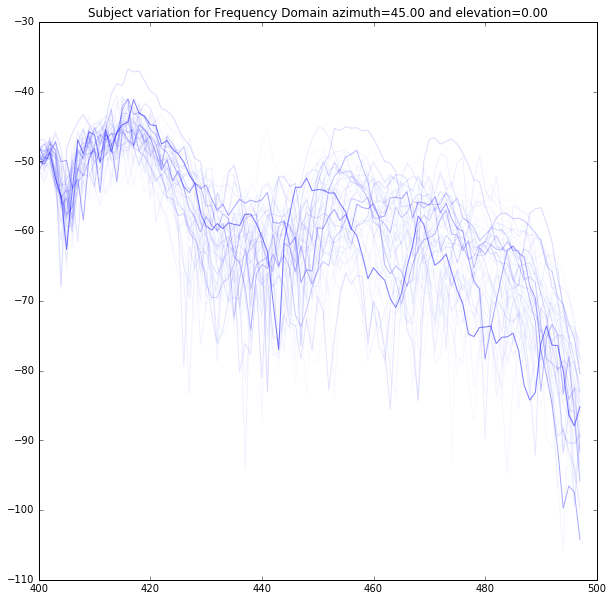

In [14]:
plt.figure(figsize=(10, 10))
#azimuth = np.random.randint(-180, 175)
#elevation = np.random.randint(-50, 90)
azimuth, elevation = 45.0, 0.0 
location = ds_1[(ds_1.azimuth == azimuth) & (ds_1.elevation == elevation)]
location2 = ds_1[(ds_1.azimuth == 0.0) & (ds_1.elevation == 0.0)]
location3 = ds_1[(ds_1.azimuth == -45.0) & (ds_1.elevation == elevation)]
range_ = range(400, 498)
l_hrtf = location.iloc[:,range_]
r_hrtf = location.iloc[:, range_]
j = 1
for i in range(1, 45):
    first = l_hrtf[location.subject_id == i].iloc[0]
    plt.plot(range_, first, c='b', alpha=1.0/(j+1))
    #plt.plot(range(98), r_hrir.iloc[i], c='r', alpha=1.0/(j+1))
    j += 1
#plt.legend(loc='upper right')
plt.title('Subject variation for Frequency Domain azimuth={:.2f} and elevation={:.2f}'.format(azimuth, elevation))
plt.show()

In [15]:
# Analayzing non-HRTF features (extracted features)
# Some of them seem to be missing
ds_1.ix[:, 1399:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
head_width,46250,14.428826,0.905161,12.646597,13.903307,14.443268,14.892092,16.203902
head_height,46250,21.377795,1.161957,18.865526,20.665188,21.311794,22.090244,23.842658
head_depth,46250,19.900724,1.312059,16.660570,19.275830,19.915320,20.870571,23.064239
pinna_offset_down,46250,3.006494,0.586056,1.408322,2.446867,3.220209,3.469709,3.772236
pinna_offset_back,46250,0.389666,0.590552,-1.170696,0.167971,0.393765,0.785692,1.899457
neck_width,46250,11.518612,0.997720,9.408768,11.020129,11.549176,12.212968,14.042607
neck_height,46250,6.177656,1.972471,1.905978,4.982187,6.340924,7.461400,10.600237
neck_depth,46250,10.477648,1.134602,7.837414,9.936521,10.372081,11.325472,12.534256
torso_top_width,46250,30.953683,2.606181,25.202642,29.566625,31.213773,32.422859,36.839476
torso_top_heigth,46250,13.429684,1.939632,9.412423,12.236193,13.005980,14.494436,17.560892


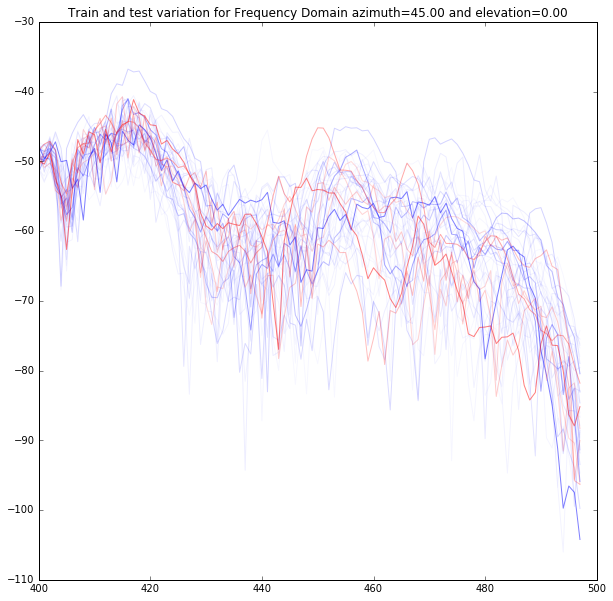

In [25]:
plt.figure(figsize=(10, 10))
#azimuth = np.random.randint(-180, 175)
#elevation = np.random.randint(-50, 90)
azimuth, elevation = 45.0, 0.0
range_ = range(400, 498)
train_location = train[((train.azimuth == azimuth) & (train.elevation == elevation))]
test_location = test[((test.azimuth == azimuth) & (test.elevation == elevation))]
l_hrtf = train_location.ix[:, range_]
l_hrtf_test = test_location.ix[:, range_]
j = 1
for i in train.subject_id.unique():
    subj_train = l_hrtf[train_location.subject_id == i].iloc[0]
    plt.plot(range_, subj_train, c='b', alpha=1.0/(j+1))
    j += 1
j = 1
for i in test.subject_id.unique():
    subj_test = l_hrtf_test[test_location.subject_id == i].iloc[0]
    plt.plot(range_, subj_test, c='r', alpha=1.0/(j+1))
    j += 1
plt.title('Train and test variation for Frequency Domain azimuth={:.2f} and elevation={:.2f}'.format(azimuth, elevation))
plt.show()

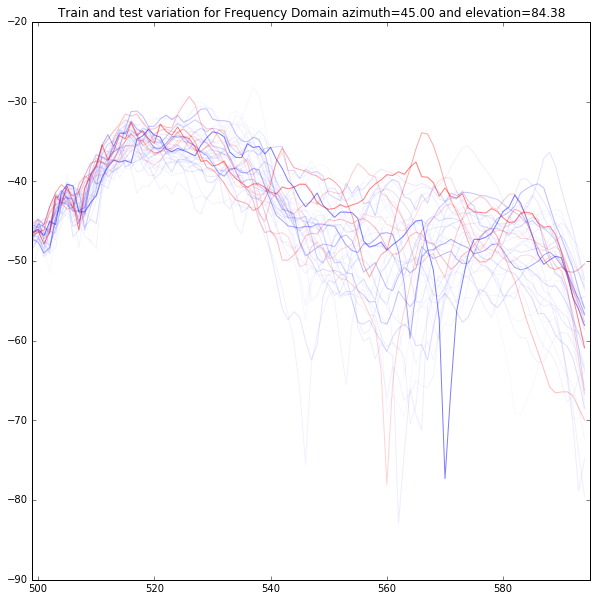

In [26]:
plt.figure(figsize=(10, 10))
#azimuth = np.random.randint(-180, 175)
#elevation = np.random.randint(-50, 90)
azimuth, elevation = 45.0, 84.375
range_ = range(499, 595)
train_location = train[((train.azimuth == azimuth) & (train.elevation == elevation))]
test_location = test[((test.azimuth == azimuth) & (test.elevation == elevation))]
l_hrtf = train_location.ix[:, range_]
l_hrtf_test = test_location.ix[:, range_]
j = 1
for i in train.subject_id.unique():
    subj_train = l_hrtf[train_location.subject_id == i].iloc[0]
    plt.plot(range_, subj_train, c='b', alpha=1.0/(j+1))
    j += 1
j = 1
for i in test.subject_id.unique():
    subj_test = l_hrtf_test[test_location.subject_id == i].iloc[0]
    plt.plot(range_, subj_test, c='r', alpha=1.0/(j+1))
    j += 1
plt.xlim(499, 595)
plt.title('Train and test variation for Frequency Domain azimuth={:.2f} and elevation={:.2f}'.format(azimuth, elevation))
plt.show()

Frequency series for subjects in Training and Test Sets

## Baseline Regression Tree model
### Dataset split
- training: 75%
- validation: 10%
- test: 15%

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error
from math import ceil

In [20]:
def split_dataset(n, training_perc=0.75, val_perc=0.1):
    train_size = int(ceil(n*training_perc))
    val_size = int(ceil(n*val_perc))
    shuffled_ix = np.random.choice(range(1, n+1), n, replace=False)
    return shuffled_ix[:train_size], shuffled_ix[train_size:train_size + val_size], shuffled_ix[train_size + val_size:]

In [21]:
# Fit regression model
# Only use this columns for the moment
cols_range = range(0, 1399) + range(-3, 0, 1)
ds_1 = ds_1.ix[:, cols_range]
n = 45

In [22]:
#train_ix, val_ix, test_ix = split_dataset(n)
#train_ix.sort()
#val_ix.sort()
#test_ix.sort()
#print 'chosen training subjects:', train_ix
#print 'chosen validation subjects:', val_ix
#print 'chosen test subjects:', test_ix

From now on, chosen users will be used for each dataset (trainig, validation and testing)

In [23]:
def get_splitted_dataset(ds):
    train_ix = [2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 22, 23,
                25, 26, 27, 28, 31, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44]
    val_ix = [7, 24, 29, 30, 38]
    test_ix = [1, 12, 20, 21, 32, 45]

    train = ds[ds.subject_id.isin(train_ix)]
    val = ds[ds.subject_id.isin(val_ix)]
    test = ds[ds.subject_id.isin(test_ix)]
    return train, val, test

## Include all features

In [17]:
# Include all features
ds_2 = df.ix[:56249].copy()
n = 45

# Substitute missing values with feature mean
means = ds_2.mean(axis=0)
ds_2 = ds_2.fillna(means)

In [24]:
train, val, test = get_splitted_dataset(ds_2)

In [39]:
# Write .csv for each set
train.to_csv('data/train.csv')
val.to_csv('data/val.csv')
test.to_csv('data/test.csv')

In [27]:
print train.shape, val.shape, test.shape

(42500, 1439) (6250, 1439) (7500, 1439)


### Building baseline model for Elevation

In [28]:
X_train, y_train = train.ix[:, :-3], train.ix[:, 'elevation']
X_test, y_test = test.ix[:, :-3], test.ix[:, 'elevation']

In [29]:
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(42500, 1436) (42500,)
(7500, 1436) (7500,)


In [45]:
# Regression Tree Baseline Model
# command: dot -Tpng tree4.dot -o tree4.png
depth = 15
regr = DecisionTreeRegressor(max_depth=depth)
regr.fit(X_train, y_train)
with open('tree' + str(depth) + '.dot', 'w') as dotfile:
    export_graphviz(
        regr,
        dotfile,
        feature_names=X_train.columns)

# Predict
y_pred = regr.predict(X_test)
loss = mean_absolute_error(y_test, y_pred)

print loss

16.3588043105


In [47]:
# Number of possible outcomes in built tree, comparte to 32 unique values of elevation
pd.Series(y_pred).nunique()

576

In [48]:
# Build dataframe to compare real values with predictions on test set
new_df = pd.concat([y_test, pd.Series(y_pred, index=y_test.index), test.ix[:, -3:]], axis=1)
new_df.to_csv('results.csv')

In [49]:
# Classification Tree Baseline Model
# command: dot -Tpng tree4.dot -o tree4.png
depth=15
c_tree = DecisionTreeClassifier(max_depth=depth)
c_tree.fit(X_train, y_train.astype(np.str))

with open('class_tree' + str(depth) + '.dot', 'w') as dotfile:
    export_graphviz(
        regr,
        dotfile,
        feature_names=X_train.columns)

# Predict
y_pred = c_tree.predict(X_test).astype(np.float64)
loss = mean_absolute_error(y_test, y_pred)

print loss

16.4865


In [50]:
# Build dataframe to compare real values with predictions on test set
new_df = pd.concat([y_test, pd.Series(y_pred, index=y_test.index), test.ix[:, -3:]], axis=1)
new_df.to_csv('results_class.csv')

In [36]:
from sklearn.neighbors import KNeighborsRegressor

In [52]:
# K-Nearest Neighbors Baseline Model

knn_regr = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_regr.fit(X_train, y_train)
# Predict
y_pred = knn_regr.predict(X_test)
loss = mean_absolute_error(y_test, y_pred)

print loss

18.6200514974


## Plot for different parameters (elevation)

In [30]:
import os, sys

# Parameters
minDepth = 2
maxDepth = 30
sizearray = maxDepth-minDepth+1

minN = 1
maxN = 10
sizearray_knn = maxN-minN+1

In [31]:
# Classification Tree Depth Search
c_tree_loss_train = np.zeros(sizearray)
c_tree_loss_test = np.zeros(sizearray)

count = 0
for i in range(minDepth,maxDepth+1):
    print("Calculating Classification Tree for depth = "+str(i))
    depth=i
    c_tree = DecisionTreeClassifier(max_depth=depth)
    c_tree.fit(X_train, y_train.astype(np.str))

    # Predict Train error
    y_pred_train = c_tree.predict(X_train).astype(np.float64)
    c_tree_loss_train[count] = mean_absolute_error(y_train, y_pred_train)
    
    # Predict Test error
    y_pred_test = c_tree.predict(X_test).astype(np.float64)
    c_tree_loss_test[count] = mean_absolute_error(y_test, y_pred_test)
    
    count += 1
    os.system('clear')


Calculating Classification Tree for depth = 2
Calculating Classification Tree for depth = 3
Calculating Classification Tree for depth = 4
Calculating Classification Tree for depth = 5
Calculating Classification Tree for depth = 6
Calculating Classification Tree for depth = 7
Calculating Classification Tree for depth = 8
Calculating Classification Tree for depth = 9
Calculating Classification Tree for depth = 10
Calculating Classification Tree for depth = 11
Calculating Classification Tree for depth = 12
Calculating Classification Tree for depth = 13
Calculating Classification Tree for depth = 14
Calculating Classification Tree for depth = 15
Calculating Classification Tree for depth = 16
Calculating Classification Tree for depth = 17
Calculating Classification Tree for depth = 18
Calculating Classification Tree for depth = 19
Calculating Classification Tree for depth = 20
Calculating Classification Tree for depth = 21
Calculating Classification Tree for depth = 22
Calculating Classific

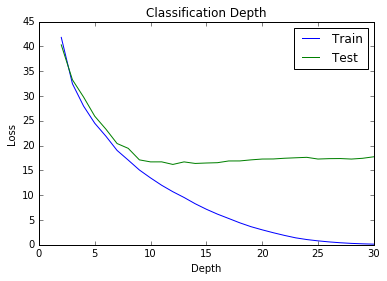

In [32]:
# Plot of Losses for different depths
# CLASSIFICATION TREES

plt.plot(np.arange(minDepth,maxDepth+1),c_tree_loss_train,label='Train')
plt.plot(np.arange(minDepth,maxDepth+1),c_tree_loss_test,label='Test')

plt.ylabel('Loss')
plt.xlabel('Depth')
plt.title('Classification Depth')
plt.legend()
plt.show()

In [33]:
# Regression Tree Depth Search
r_tree_loss_train = np.zeros(sizearray)
r_tree_loss_test = np.zeros(sizearray)

count = 0
for i in range(minDepth,maxDepth+1):
    print("Calculating Regression Tree for depth = "+str(i))
    depth=i
    r_tree = DecisionTreeRegressor(max_depth=depth)
    r_tree.fit(X_train, y_train)

    # Predict Train error
    y_pred_train = r_tree.predict(X_train).astype(np.float64)
    r_tree_loss_train[count] = mean_absolute_error(y_train, y_pred_train)
    
    # Predict Test error
    y_pred_test = r_tree.predict(X_test).astype(np.float64)
    r_tree_loss_test[count] = mean_absolute_error(y_test, y_pred_test)
    
    count += 1
    os.system('clear')

Calculating Regression Tree for depth = 2
Calculating Regression Tree for depth = 3
Calculating Regression Tree for depth = 4
Calculating Regression Tree for depth = 5
Calculating Regression Tree for depth = 6
Calculating Regression Tree for depth = 7
Calculating Regression Tree for depth = 8
Calculating Regression Tree for depth = 9
Calculating Regression Tree for depth = 10
Calculating Regression Tree for depth = 11
Calculating Regression Tree for depth = 12
Calculating Regression Tree for depth = 13
Calculating Regression Tree for depth = 14
Calculating Regression Tree for depth = 15
Calculating Regression Tree for depth = 16
Calculating Regression Tree for depth = 17
Calculating Regression Tree for depth = 18
Calculating Regression Tree for depth = 19
Calculating Regression Tree for depth = 20
Calculating Regression Tree for depth = 21
Calculating Regression Tree for depth = 22
Calculating Regression Tree for depth = 23
Calculating Regression Tree for depth = 24
Calculating Regress

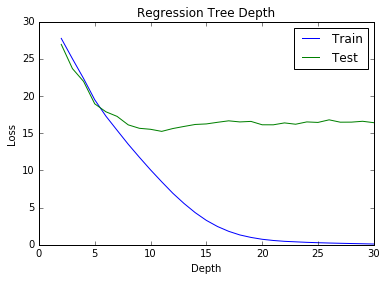

In [40]:
# Plot of Losses for different depths
# REGRESSION TREES

plt.plot(np.arange(minDepth,maxDepth+1),r_tree_loss_train,label='Train')
plt.plot(np.arange(minDepth,maxDepth+1),r_tree_loss_test,label='Test')

plt.ylabel('Loss')
plt.xlabel('Depth')
plt.title('Regression Tree Depth')
plt.legend()
plt.show()

In [37]:
# K-Nearest Neighbors K Search

knn_loss_train = np.zeros(sizearray_knn)
knn_loss_test = np.zeros(sizearray_knn)

count = 0
for i in range(minN,maxN+1):
    print("Calculating Nearest Neighbors for K = "+str(i))
    knn = KNeighborsRegressor(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)

    # Predict Train error
    y_pred_train = knn.predict(X_train)
    knn_loss_train[count] = mean_absolute_error(y_train, y_pred_train)
    
    # Predict Test error
    y_pred_test = knn.predict(X_test)
    knn_loss_test[count] = mean_absolute_error(y_test, y_pred_test)
    
    count += 1

Calculating Nearest Neighbors for K = 1
Calculating Nearest Neighbors for K = 2
Calculating Nearest Neighbors for K = 3
Calculating Nearest Neighbors for K = 4
Calculating Nearest Neighbors for K = 5
Calculating Nearest Neighbors for K = 6
Calculating Nearest Neighbors for K = 7
Calculating Nearest Neighbors for K = 8
Calculating Nearest Neighbors for K = 9
Calculating Nearest Neighbors for K = 10


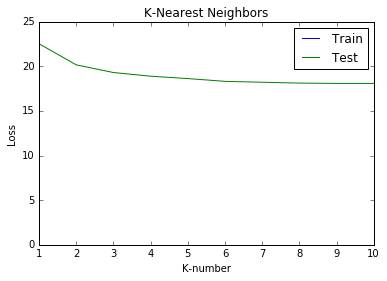

In [41]:
# Plot of Losses for different depths
# K-NEAREST NEIGHBORS

plt.plot(np.arange(minN,maxN+1),knn_loss_train,label='Train')
plt.plot(np.arange(minN,maxN+1),knn_loss_test,label='Test')

plt.ylabel('Loss')
plt.xlabel('K-number')
plt.title('K-Nearest Neighbors')
plt.legend()
plt.show()

In [49]:
# BEST PARAMETERS ELEVATION
Depths = np.arange(minDepth,maxDepth+1);
KNs = np.arange(minN,maxN+1)
ind_c = np.where(c_tree_loss_test==min(c_tree_loss_test))
ind_r = np.where(r_tree_loss_test==min(r_tree_loss_test))
ind_k = np.where(knn_loss_test==min(knn_loss_test))
print("For Classification Tree, the best loss is " + str(min(c_tree_loss_test)) +" for depth = " +str(Depths[ind_c]))
print("For Regression Tree, the best loss is " + str(min(r_tree_loss_test)) +" for depth = " +str(Depths[ind_r]))
print("For K-Nearest Neighbors, the best loss is " + str(min(knn_loss_test)) +" for K = " +str(KNs[ind_k]))

For Classification Tree, the best loss is 16.203 for depth = [12]
For Regression Tree, the best loss is 15.2453435403 for depth = [11]
For K-Nearest Neighbors, the best loss is 18.0748171315 for K = [10]


# Repeat the models for the azimuth

## Data Prep

In [39]:
X2_train, y2_train = train.ix[:, :-3], train.ix[:, 'azimuth']
X2_test, y2_test = test.ix[:, :-3], test.ix[:, 'azimuth']

print X2_train.shape, y2_train.shape
print X2_test.shape, y2_test.shape

(42500, 1436) (42500,)
(7500, 1436) (7500,)


## Parameter Search (azimuth)

In [50]:
from IPython.core.display import clear_output

In [51]:
# Classification Tree Depth Search
c_tree_loss_train = np.zeros(sizearray)
c_tree_loss_test = np.zeros(sizearray)

count = 0
for i in range(minDepth,maxDepth+1):
    print("Calculating Classification Tree for depth = "+str(i))
    depth=i
    c_tree = DecisionTreeClassifier(max_depth=depth)
    c_tree.fit(X2_train, y2_train.astype(np.str))

    # Predict Train error
    y2_pred_train = c_tree.predict(X2_train).astype(np.float64)
    c_tree_loss_train[count] = mean_absolute_error(y2_train, y2_pred_train)
    
    # Predict Test error
    y2_pred_test = c_tree.predict(X2_test).astype(np.float64)
    c_tree_loss_test[count] = mean_absolute_error(y2_test, y2_pred_test)
    
    count += 1
    clear_output()


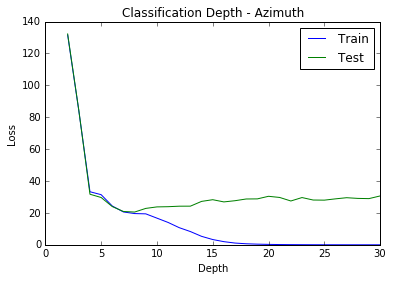

In [52]:
# Plot of Losses for different depths
# CLASSIFICATION TREES

plt.plot(np.arange(minDepth,maxDepth+1),c_tree_loss_train,label='Train')
plt.plot(np.arange(minDepth,maxDepth+1),c_tree_loss_test,label='Test')

plt.ylabel('Loss')
plt.xlabel('Depth')
plt.title('Classification Depth - Azimuth')
plt.legend()
plt.show()

In [53]:
# Regression Tree Depth Search
r_tree_loss_train = np.zeros(sizearray)
r_tree_loss_test = np.zeros(sizearray)

count = 0
for i in range(minDepth,maxDepth+1):
    print("Calculating Regression Tree for depth = "+str(i))
    depth=i
    r_tree = DecisionTreeRegressor(max_depth=depth)
    r_tree.fit(X2_train, y2_train)

    # Predict Train error
    y2_pred_train = r_tree.predict(X2_train).astype(np.float64)
    r_tree_loss_train[count] = mean_absolute_error(y2_train, y2_pred_train)
    
    # Predict Test error
    y2_pred_test = r_tree.predict(X2_test).astype(np.float64)
    r_tree_loss_test[count] = mean_absolute_error(y2_test, y2_pred_test)
    
    count += 1
    clear_output()

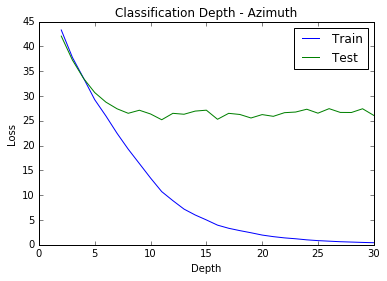

In [54]:
# Plot of Losses for different depths
# REGRESSION TREES

plt.plot(np.arange(minDepth,maxDepth+1),r_tree_loss_train,label='Train')
plt.plot(np.arange(minDepth,maxDepth+1),r_tree_loss_test,label='Test')

plt.ylabel('Loss')
plt.xlabel('Depth')
plt.title('Classification Depth - Azimuth')
plt.legend()
plt.show()

In [55]:
# K-Nearest Neighbors K Search

knn_loss_train = np.zeros(sizearray_knn)
knn_loss_test = np.zeros(sizearray_knn)

count = 0
for i in range(minN,maxN+1):
    print("Calculating Nearest Neighbors for K = "+str(i))
    knn = KNeighborsRegressor(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)

    # Predict Train error
    y2_pred_train = knn.predict(X2_train)
    knn_loss_train[count] = mean_absolute_error(y2_train, y2_pred_train)
    
    # Predict Test error
    y2_pred_test = knn.predict(X2_test)
    knn_loss_test[count] = mean_absolute_error(y2_test, y2_pred_test)
    
    count += 1
    clear_output()

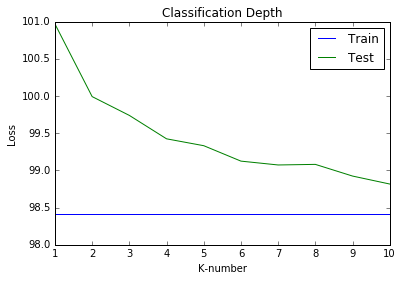

In [56]:
# Plot of Losses for different depths
# K-NEAREST NEIGHBORS

plt.plot(np.arange(minN,maxN+1),knn_loss_train,label='Train')
plt.plot(np.arange(minN,maxN+1),knn_loss_test,label='Test')

plt.ylabel('Loss')
plt.xlabel('K-number')
plt.title('Classification Depth')
plt.legend()
plt.show()

In [60]:
# BEST PARAMETERS AZIMUTH
Depths = np.arange(minDepth,maxDepth+1);
KNs = np.arange(minN,maxN+1)
ind_c = np.where(c_tree_loss_test==min(c_tree_loss_test))
ind_r = np.where(r_tree_loss_test==min(r_tree_loss_test))
ind_k = np.where(knn_loss_test==min(knn_loss_test))
print("For Classification Tree, the best loss is " + str(min(c_tree_loss_test)) +" for depth = " +str(Depths[ind_c]))
print("For Regression Tree, the best loss is " + str(min(r_tree_loss_test)) +" for depth = " +str(Depths[ind_r]))
print("For K-Nearest Neighbors, the best loss is " + str(min(knn_loss_test)) +" for K = " +str(KNs[ind_k]))

For Classification Tree, the best loss is 20.5393333333 for depth = [8]
For Regression Tree, the best loss is 25.2128247171 for depth = [11]
For K-Nearest Neighbors, the best loss is 98.8167679718 for K = [10]


In [58]:
knn_loss_test.shape

(10,)